# Effective condunctanse in inhomogeneouse media
we want to solve the following equation:

$A_{eff}(a) = min_{u(x)} \int_{[0,1]^d} a(x) ||-\nabla u(x) + \xi||_2^2$.

the data set were generated previousely using Octave, then seperated to two distinct set.

In [1]:
# Utilities : 
import numpy as np
import os
# Keras :
# backend
from keras import backend as K
# layers :
from keras.layers import Input, Dense, add, Activation , Conv1D, Flatten ,GlobalAveragePooling1D , Lambda
# model :
from keras.models import Model, model_from_json, model_from_yaml
# optimizer :
from keras import optimizers 

Using TensorFlow backend.


setting up network parameteres:

In [2]:
# network input parameters 

n = 8            # number of the input layer neurons 

# convolutional layers parameters

alpha = 16       # number of channels in convolutional layers
ks = 1           # Kernel Size

# optimizer (NAdam) parameters

lr = 0.005       # learning rate
beta_1=0.9       # beta 1
beta_2=0.999     # beta 2

# model fitting parameters

epochs = 100     # epochs
batch_size = 150 # batch size

loading the Data to train and test data sets.

* Step 1 : loading the data set
* Step 2 : shuffling the data set
* Step3  : seperating data and lable parts

In [3]:
#test :
test = np.loadtxt('data/test.csv', delimiter=',')
np.random.shuffle(test)
d_test = np.array(test[:,0:n])
l_test = np.array(test[:,n])

#train :
train = np.loadtxt('data/train.csv', delimiter=',')
np.random.shuffle(train)
data = np.array(train[:,0:n])
labels = np.array(train[:,n])

Next we need to expand the dimensions of our input data, so it can feed directly to the convolutional layers. Please note that, as I did in NLSE, it could be done in the network with `Reshape` layer too.

In [4]:
# from (height, width) to (height, width, depth)
data = np.expand_dims(data, axis=2) 
d_test = np.expand_dims(d_test, axis=2) 

Next, we would like to define our model. The model is consists of three part. First part is consists of some convolutional layers with kernel size 1, Second part is a sum-pooling block, and, finally, third part is consists of some convolutional layers with kernel size 1. Note that there is a symmetric relation between first and third parts.

In [5]:
inputTensor = Input(shape=(n,1))
print inputTensor

stack = []

# Part 1: Convolutional layers:
# SubPart 1.1 : Expanding the input to alpha channels and performing convolutions with kernel size of ks
stack.append(Conv1D(alpha, ks, strides=1, input_shape=(1,n,1),padding='same', activation='relu')(inputTensor))
stack.append(Conv1D(alpha, ks, strides=1, padding='same', activation='relu')(add([stack[len(stack)-1],inputTensor])))
stack.append(Conv1D(alpha, ks, strides=1, padding='same', activation='relu')(add([stack[len(stack)-1],inputTensor])))
# SubPart 1.2 : Flattening the results into 1 chanel
stack.append(Conv1D(1, ks, strides=1, padding='same', activation='linear')(add([stack[len(stack)-1],inputTensor])))

# Part 2: Sum-Pooling:
# there is no sumpooling direct layer, so we have to use an global average layer first :
stack.append(GlobalAveragePooling1D(data_format='channels_last')(add([stack[len(stack)-1],inputTensor])))
# and then multiply the result in the total number of elements throughh a lambda layer next:
stack.append(Lambda(lambda x: x * data.shape[1])(stack[len(stack)-1]))

# Part 3: Convolutions equivalent to Dense layers
# SubPart 3.1 : Expanding the input to alpha channels and performing convolution with kernel size 'ks'
stack.append(Conv1D(alpha, ks, strides=1, padding='same', activation='relu')(add([stack[len(stack)-1],inputTensor])))
stack.append(Conv1D(alpha, ks, strides=1, padding='same', activation='relu')(add([stack[len(stack)-1],inputTensor])))
stack.append(Conv1D(alpha, ks, strides=1, padding='same', activation='relu')(add([stack[len(stack)-1],inputTensor])))

# SubPart 3.2 : Flattening alpha channels to 1 channel, so the whole part can be viewd as a dense layer
#shall the kernel size remain 1? or we can use a more dynamic kernel size here
stack.append(Conv1D(1, ks, strides=1, padding='same', activation='linear')(add([stack[len(stack)-1],inputTensor])))

# SubPart 3.3 : Flattening the result so it can be fed into the output layer
stack.append(Flatten()(stack[len(stack)-1])) 

# SubPart 3.4 : The output layer which is a n -> 1 dense layer and will give us one single output 
finalOutput = Dense(1)(stack[len(stack)-1])
print finalOutput

# Defining the Actual Model
model = Model(inputTensor,finalOutput)

Tensor("input_1:0", shape=(?, 8, 1), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)


Lets train the network. The loss function is choosen to be mean squared error.

In [9]:
import tensorflow as tf
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
  """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

  def __init__(self, patience=20):
    super(EarlyStoppingAtMinLoss, self).__init__()

    self.patience = patience

    # best_weights to store the weights at which the minimum loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = logs.get('loss')
    if np.less(current, self.best):
      self.best = current
      self.wait = 0
      # Record the best weights if current results is better (less).
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        print('Restoring model weights from the end of the best epoch.')
        self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))
    


# Setting the optimizer parameters
opt = optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
# compiling the model
model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mae'])
# fitting the data with model (learning process)
model.fit(data, labels, epochs=epochs, batch_size=batch_size, callbacks=[EarlyStoppingAtMinLoss(15)])  
# evaluating the results
loss, MAE= model.evaluate(d_test, l_test)
# printing the final results on test data set
print('Loss Funcion Minima On test dataset : %.8f' % (loss))
print('Mean Absolute Error On test dataset : %.8f' % (MAE))

Epoch 1/100
127500/127500 [==============================] - 37s 290us/step - loss: 0.0387 - mean_absolute_error: 0.1087
Epoch 2/100
127500/127500 [==============================] - 32s 251us/step - loss: 0.0046 - mean_absolute_error: 0.0535
Epoch 3/100
127500/127500 [==============================] - 32s 252us/step - loss: 0.0045 - mean_absolute_error: 0.0526
Epoch 4/100
127500/127500 [==============================] - 34s 264us/step - loss: 0.0045 - mean_absolute_error: 0.0527
Epoch 5/100
127500/127500 [==============================] - 33s 262us/step - loss: 0.0044 - mean_absolute_error: 0.0517
Epoch 6/100
127500/127500 [==============================] - 32s 253us/step - loss: 0.0044 - mean_absolute_error: 0.0521
Epoch 7/100
127500/127500 [==============================] - 33s 262us/step - loss: 0.0038 - mean_absolute_error: 0.0480
Epoch 8/100
127500/127500 [==============================] - 35s 275us/step - loss: 0.0033 - mean_absolute_error: 0.0451
Epoch 9/100
127500/127500 [=====

Epoch 65/100
127500/127500 [==============================] - 31s 241us/step - loss: 3.3236e-05 - mean_absolute_error: 0.00411s - loss: 3.2399e-05 - mean_
Epoch 66/100
127500/127500 [==============================] - 32s 251us/step - loss: 3.3167e-05 - mean_absolute_error: 0.0040
Epoch 67/100
127500/127500 [==============================] - 33s 260us/step - loss: 3.3584e-05 - mean_absolute_error: 0.0041
Epoch 68/100
127500/127500 [==============================] - 32s 248us/step - loss: 3.0653e-05 - mean_absolute_error: 0.0039
Epoch 69/100
127500/127500 [==============================] - 30s 232us/step - loss: 3.3338e-05 - mean_absolute_error: 0.0041
Epoch 70/100
127500/127500 [==============================] - 31s 243us/step - loss: 3.3066e-05 - mean_absolute_error: 0.0038
Epoch 71/100
127500/127500 [==============================] - 34s 264us/step - loss: 3.5430e-05 - mean_absolute_error: 0.00371s - loss: 3.2325e-05 - mean_
Epoch 72/100
127500/127500 [==============================] 

Next, we want to make some predictions, and we do some error analysis:

In [14]:
predicted_A_eff = model.predict(d_test,batch_size=150)
print('mean of predicted A_eff : %.8f' % (np.mean(predicted_A_eff)))
print('norm of the mean of the commited error : %.8f' % (np.linalg.norm(np.mean(predicted_A_eff) - np.mean(l_test))))

mean of predicted A_eff : 0.76800650
norm of the mean of the commited error : 0.00102100


Here is the norm of a vector created whose elements are the commited error over all samples:

In [15]:
err =[]
for i in range(len(predicted_A_eff)):
    err.append(predicted_A_eff[i]-l_test[i])
err = np.array(err)
print('mean of L2 commited error: %.8f'%(np.linalg.norm(err)))

mean of L2 commited error: 0.34214979


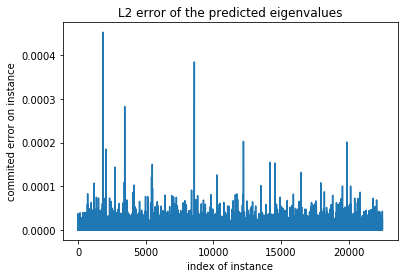

In [37]:
L2_Errors = []
for i in range(predicted_A_eff.shape[0]):
    L2_Errors.append((l_test[i] - predicted_A_eff[i])**2)

import matplotlib.pyplot as plt
plt.plot(L2_Errors)
plt.title('L2 error of the predicted eigenvalues')
plt.ylabel('commited error on instance')
plt.xlabel('index of instance')
plt.show()

In [39]:
#calculating percentiles:
#setting tresholds :
T1 = 0
T2 = 5e-6
T3 = 5e-5
T4 = 5e-4
T5 = 5e-3
T6 = 5e-2
T7 = 5e-1
S1=S2=S3=S4=S5=S6=0.0
for item in L2_Errors:
    if (item[0]>=T1 and item[0]< T2):
        S1 = S1 + 1
    elif (item[0]>=T2 and item[0]< T3):
        S2 = S2 + 1
    elif (item[0]>=T3 and item[0]< T4):
        S3 = S3 + 1
    elif (item[0]>=T4 and item[0]< T5):
        S4 = S4 + 1
    elif (item[0]>=T5 and item[0]< T6):
        S5 = S5 + 1
    elif (item[0]>=T6 and item[0]< T7):
        S6 = S6 + 1
print('Percentage of the commited error between 0,5e-6 is: %.8f' % ((S1/len(L2_Errors)) * 100))
print('Percentage of the commited error between 5e-6,5e-5 is: %.8f' % ((S2/len(L2_Errors)) * 100))
print('Percentage of the commited error between 5e-5,5e-4 is: %.8f' % ((S3/len(L2_Errors)) * 100))
print('Percentage of the commited error between 5e-4,5e-3 is: %.8f' % ((S4/len(L2_Errors)) * 100))
print('Percentage of the commited error between 5e-3,5e-2 is: %.8f' % ((S5/len(L2_Errors)) * 100))
print('Percentage of the commited error between 5e-2,5e-1 is: %.8f' % ((S6/len(L2_Errors)) * 100))

Percentage of the commited error between 0,5e-6 is: 71.09333333
Percentage of the commited error between 5e-6,5e-5 is: 28.28888889
Percentage of the commited error between 5e-5,5e-4 is: 0.61777778
Percentage of the commited error between 5e-4,5e-3 is: 0.00000000
Percentage of the commited error between 5e-3,5e-2 is: 0.00000000
Percentage of the commited error between 5e-2,5e-1 is: 0.00000000


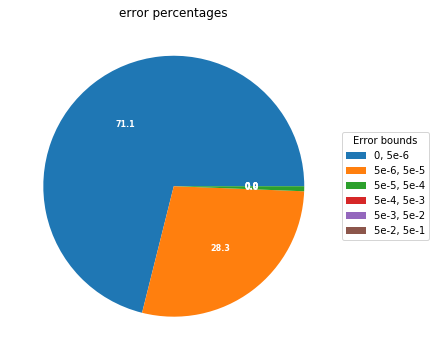

In [41]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))


data_to_plot = [(S1/len(L2_Errors)),
          (S2/len(L2_Errors)),
          (S3/len(L2_Errors)),
          (S4/len(L2_Errors)),
          (S5/len(L2_Errors)),
          (S6/len(L2_Errors))]
ingredients = ["0, 5e-6", 
               "5e-6, 5e-5",
               "5e-5, 5e-4",
               "5e-4, 5e-3",
               "5e-3, 5e-2",
               "5e-2, 5e-1",]


def func(pct, allvals):
    return "{:.1f}".format(pct)


wedges, texts, autotexts = ax.pie(data_to_plot, autopct=lambda pct: func(pct, data_to_plot),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Error bounds",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("error percentages")

plt.show()

Next, we want to see the out put of the first part. and verify if it looks like a reciprocal function or not. References to look at for this work:

* https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer

* https://itnspotlight.com/dissecting-keras-neural-networks-accessing-weights-and-hidden-layers/

* https://keras.io/layers/about-keras-layers/

* https://keras.io/models/about-keras-models/


In [16]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 1)         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8, 16)        32          input_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 8, 16)        0           conv1d_1[0][0]                   
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8, 16)        272         add_1[0][0]                      
__________

In [50]:
# to get this layer name, use a model.summary() and pick the ID
layer_name = 'conv1d_4'

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(d_test)

Lets process data a bit before ploting it:

In [53]:
xs = d_test.reshape((d_test.shape[0],d_test.shape[2],d_test.shape[1])).flatten()
ys = intermediate_output.reshape((intermediate_output.shape[0],intermediate_output.shape[2],intermediate_output.shape[1])).flatten()

If we do not sort our dictionary, the plot would look like a childs drawing!

In [54]:
dict1 = np.hstack((xs.reshape((xs.shape[0],1)), ys.reshape((ys.shape[0],1))))
dict1.sort(axis=0)
np.unique(dict1, axis=0)

array([[  0.30000123, -13.49671841],
       [  0.30000996, -13.49651337],
       [  0.30001437, -13.49640942],
       ...,
       [  1.49996473,   3.02851343],
       [  1.49998212,   3.02856302],
       [  1.49999522,   3.02859974]])

Lets make the plot :

/home/samim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


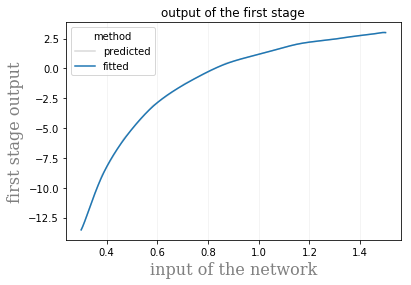

In [55]:

import matplotlib.pyplot as plt
plt.plot(dict1[:,0], dict1[:,1], '-', color='grey', alpha=.3,  label='predicted')
x = dict1[:,0]
y = dict1[:,1]
z = np.polyfit(x, y, 15)
p = np.poly1d(z)

tpp =[]
for i in dict1[:,0]:
    tpp.append(p(i))  

plt.plot(x, tpp,'-', alpha=1,  label='fitted')

# here is more nice options for plotting, But I prefered to keep it simple

plt.grid(axis='x', color='0.95')
plt.legend(title='method')
plt.title('output of the first stage')

font = {'family': 'serif',
        'color':  'gray',
        'weight': 'normal',
        'size': 16,
        }


plt.xlabel('input of the network', fontdict=font)
plt.ylabel('first stage output', fontdict=font)

plt.savefig('output_of_the_second_stage.png')
#to get it as svg directly, but I prefer using Inkscape convertor for no reason 
#plt.savefig('output_of_the_second_stage.pdf')

plt.show()

Lets save this oplots data for later uses

In [32]:
np.savetxt('data/fitted.csv', [x, tpp],delimiter=',')
np.savetxt('data/predicted.csv', [x, dict1[:,1]],delimiter=',')

During the later plot processing, I find this to be interesting: accessing the weights and biases of a particular layer

In [33]:
print("wights: " ,model.get_layer("conv1d_4").get_weights()[0])
print("bias: ",model.get_layer("conv1d_4").get_weights()[1])
print("config: ",model.get_layer("conv1d_4").get_config())

('wights: ', array([[[ 0.63494915],
        [-0.10541237],
        [ 0.76677436],
        [-0.00666247],
        [-0.6396661 ],
        [ 0.80505115],
        [ 0.09988046],
        [-0.4912386 ],
        [ 0.21556318],
        [ 0.15950036],
        [ 0.74047154],
        [ 0.5420216 ],
        [-0.41928333],
        [-0.5895055 ],
        [ 0.24533549],
        [ 0.8478522 ]]], dtype=float32))
('bias: ', array([-1.179834], dtype=float32))
('config: ', {'padding': 'same', 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'conv1d_4', 'bias_regularizer': None, 'filters': 1, 'bias_constraint': None, 'activation': 'linear', 'trainable': True, 'data_format': 'channels_last', 'kernel_constraint': None, 'strides': (1,), 'dilation_rate': (1,), 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'use_bias': True, 'activity_regularizer': None, 'kernel_size': (1

Finally, lets save the model to the disk:

In [34]:
model.save('data/my_model.h5')